<a href="https://colab.research.google.com/github/NavneetSajwan/Clothing-Classifier/blob/master/Clothing_Classsifier_with_FastAI_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Before you run any of the code below, make sure you are working in GPU MODE.

In [0]:
# importing the necessary modules
from fastai import *
from fastai.vision import *
import warnings
warnings.filterwarnings("ignore") # hides all types of warnings from displaying onscreen

# **Importing the data**


**1.   Upload the data directly into Google Colaboratory VM (Virtual Machine) and unzip it in VM itself:** Google Colaboratory VM provides **temporary storage** for our data. It needs to be uploaded every time a new instance is created. Our data is a zip file of around 1 GB, so it's **time-expensive** option for us. Once the instance is reset both zipped and unzipped data are gone.

**2.   Upload the data into Google Drive, unzip it there and access it from drive directly:** It sounds a good idea to upload and unzip the data in google drive, as drive will store both zipped and unzipped data permanantly. But turns out, it's really  not. Unzipping data into drive **takes huge time**. Considering  the fact that it's a one time thing , we might allow it but we still have to fetch batches of data from drive and that again **takes a lot of time**.

**3.   Upload the data into Google Drive, unzip it in VM and access it from VM:** In this case, we get **permanent storage** to zipped data. Huge **time saver**(and wifi data saver too!). Unzipping data into `VM from drive` is **very fast** compared to unzipping in `drive from drive`. Again saves a lot of our time. The last point of concern is how fast can data be accessed from VM? yet again , turns out **very fast** compared to drive.









**Zipped Data is already stored in google drive. So, we mount the drive first.**


In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


**Now we *quietly* unzip the data to our current working directory(in our VM)**. The '-q' allows us to unzip the data wihout listing the file names. 'q' stands for quitely!

In [0]:
!unzip -q '/content/drive/My Drive/data.zip'

**Training the model can take a lot of time depending on the size of the data.** We don't want to lose our trained model, so we save our model to a permanent location. 

In [0]:
root_dir = "/content/drive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

**Making a directory in google drive to save our models**. It's a one time run.

In [0]:
os.mkdir('/content/drive/My Drive/fastai-v3/data/clothing2')

We set our path to our newly created directory. A folder named 'models' will automatically be created to this directory to store our models.

In [0]:
path= Path(base_dir + 'data/clothing2')

**Displaying the dataframe containing File paths and labels**

In [7]:
df = pd.read_csv("File_finale8.csv")
df.head(10)

,PATH,LABELS
0,data/women/Activewear/6r022qmeh39s5sb1eh0s03ab...,female Activewear Tops Upperwear(inner)
1,data/men/Activewear/s0ln1iqig80937e6ss6grbmodo...,male Activewear Tshirts Upperwear(inner)
2,data/men/Activewear/a34anl1bb2j7oro7mrker8sr0c...,male Activewear Tshirts Upperwear(inner)
3,data/men/Activewear/ca76acdlakcj7inlah1g3njojl...,male Activewear Pants Bottomwear
4,data/women/Activewear/ra5i515s6md70js8s8a08l9n...,female Activewear Tshirts Upperwear(inner)
5,data/men/Activewear/5lnrqhjjd70e69a3j70llrqq3s...,male Activewear
6,data/men/Activewear/2ca9gh6qmggqs3kjffes106rd9...,male Activewear Pants Bottomwear
7,data/women/Activewear/94igbsahqf3fn0diq1msij27...,female Activewear
8,data/women/Activewear/dgbplesl54ja0e1n3mha66o8...,female Activewear Tshirts Upperwear(inner)
9,data/men/Activewear/87pnfd0abqe994056rqeerkqj9...,male Activewear Jackets Upperwear(outer)


# **Creating a DataBunch Object from our data**

In [0]:
np.random.seed(39) # set random seed so we always get the same validation set
src = (ImageList.from_csv('/content', 'File_finale8.csv',  )
       # Load data from csv
       .random_split_by_pct(0.35)
       # split data into training and validation set (35% validation)
       .label_from_df(label_delim=' ')
       # label data using the tags column (second column is default)
)
data = (src.transform( size= 224 )
        .databunch(bs= 128).normalize(imagenet_stats))

In [9]:
# Let's pring the classes we have in our data
data.classes

['Activewear',
 'Bottomwear',
 'Dresses',
 'Dungarees',
 'Ethnicwear',
 'Fullbodywear',
 'Innerwear_and_Sleepwear',
 'Jackets',
 'Jeans',
 'Jeggings',
 'Jumpsuits_and_Bodysuits',
 'Lingerie_and_Sleepwear',
 'Pants',
 'Shirts',
 'Shorts',
 'Skirts',
 'Suits',
 'Swimwear',
 'Tops',
 'Tshirts',
 'Upperwear(inner)',
 'Upperwear(outer)',
 'female',
 'male']

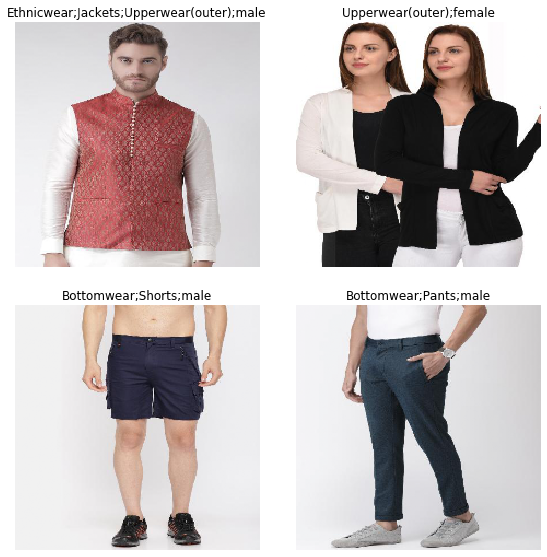

In [10]:
# Displaying a handful of images alongwith their respective labels
data.show_batch(rows=2, figsize=(8,8))

## **Creating the model**

1.   **Model:** I have chosen **resnet101** for this problem. I began with a resnet50 but  during the training procedure it turned out that the training loss was constantly higher than the validation loss. This generally happens when the model is underfitting. Hence, a more complex model may suit better. Resnet101 solved this problem of underfitting.

2.   **Evaluation Metric:** Standard choice was to use `accuracy_thresh` (Threshold accuracy). But a better option is fbeta score because it takes **Precision** and **Recall** into acccount. 

3.   **What is partial?:** Partial functions allow us to fix a certain number of arguments of a function and generate a new function. In our case we use `accuracy_thresh` with a threshold of **0.57** and `fbeta` with a threshold of **0.2**.

4.   **Transfer Learning:**  Taking up a pretrained model decreases the training time dramatically. I have taken a resnet101 pretrained on ImageNet data. Why does finetuning a pretrained model help? Because it has already learnt to identify many basic and complex shapes. 



In [0]:
arch = models.resnet101

In [12]:
acc_02 = partial(accuracy_thresh, thresh=0.57) 
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth
100%|██████████| 170M/170M [00:02<00:00, 75.4MB/s]


In [0]:
learn.freeze() # freezes the weights of all the layers except the last one. 
#This means that during training only the parameters for the last layer will be modified.

In [0]:
# Finds the lerning where the loss decreases the fastest
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


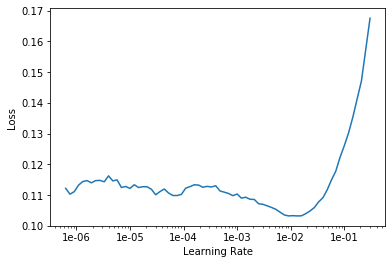

In [0]:
# plots the loss against the learning rate
learn.recorder.plot()

In [0]:
# A rule of thumb to spot the best learning rate is to chose a learning rate at least 10 times smaller than the smallest loss
lr = 1e-3

**What is fit_one_cycle method? :** According to Fastai docs, it fits a model with the 1 cycle policy. One Cycle Policy uses cyclic learning rates while training the model. More on One Cycle Policy:  https://arxiv.org/pdf/1803.09820

In [0]:
learn.fit_one_cycle(4, slice(lr) ) 

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.075689,0.067692,0.972821,0.912741,16:28
1,0.063905,0.060089,0.975766,0.924101,16:12
2,0.052662,0.057476,0.977198,0.928044,16:20
3,0.047890,0.057002,0.977431,0.929395,16:12


It must be noted that **initially the training loss was higher than the valdation loss**. It hints at the fact that the model is **underfitting**. But, luckily not for long, just after two epochs training loss becomes lower.

In [0]:
learn.save( path/'models/stage-1-rn101-224') # we should save the model to a permanent location. 
#As you can see the model took around 64 minutes to train.

In [13]:
learn.load(path/'models/stage-1-rn101-224')# With this line, we can directly load the model to our GPU 
#and we don't have to retrain the model back from epoch 0

Learner(data=ImageDataBunch;

Train: LabelList (32632 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: MultiCategoryList
male;Activewear;Tshirts;Upperwear(inner),male;Activewear;Tshirts;Upperwear(inner),male;Activewear;Pants;Bottomwear,male;Activewear,male;Activewear;Pants;Bottomwear
Path: /content;

Valid: LabelList (17570 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: MultiCategoryList
female;Ethnicwear,male;Tshirts;Upperwear(inner),male;Pants;Bottomwear,female;Lingerie_and_Sleepwear,female;Lingerie_and_Sleepwear
Path: /content;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilat

Now, we can go ahead and fine tune all the parameters of the model.

In [0]:
learn.unfreeze()# unfreezes the entire model and makes all the parameters available for training.

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


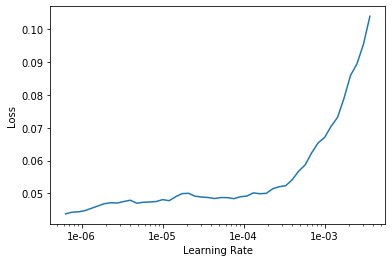

In [0]:
learn.recorder.plot()

This is a tricky one! For the lower limit of the loss, choose a point well before the sharp rise in the loss increases. For the upper limit, divide the previous learning rate by 5, `lr/5`.

In [0]:
learn.fit_one_cycle(4, slice(4e-5,lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.059472,0.063637,0.974661,0.919416,21:17
1,0.046568,0.047722,0.981112,0.941880,21:17
2,0.025733,0.042115,0.984151,0.951331,21:19
3,0.013392,0.040560,0.985254,0.953913,21:16


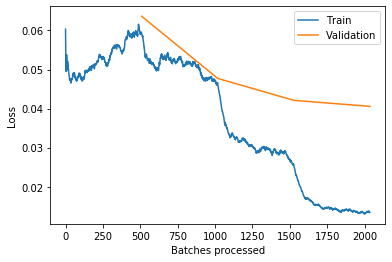

In [0]:
learn.recorder.plot_losses()

In [0]:
learn.save(path/'models/stage-2-rn101-224')# save the stage two of the model

In [14]:
learn.load(path/'models/stage-2-rn101-224')

Learner(data=ImageDataBunch;

Train: LabelList (32632 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: MultiCategoryList
male;Activewear;Tshirts;Upperwear(inner),male;Activewear;Tshirts;Upperwear(inner),male;Activewear;Pants;Bottomwear,male;Activewear,male;Activewear;Pants;Bottomwear
Path: /content;

Valid: LabelList (17570 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: MultiCategoryList
female;Ethnicwear,male;Tshirts;Upperwear(inner),male;Pants;Bottomwear,female;Lingerie_and_Sleepwear,female;Lingerie_and_Sleepwear
Path: /content;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilat

# **Model Interpretation**

In [0]:
interp=  ClassificationInterpretation.from_learner(learn)

54 misclassified samples over 17570 samples in the validation set.


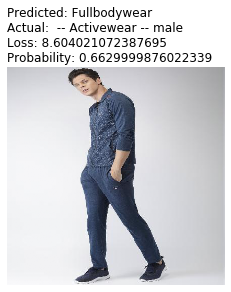

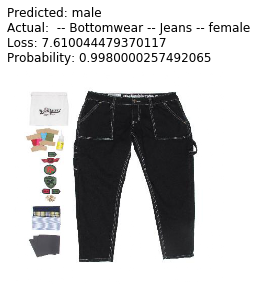

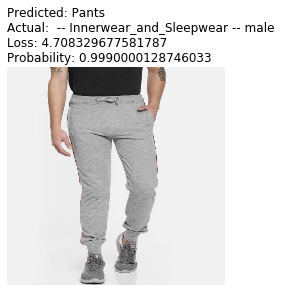

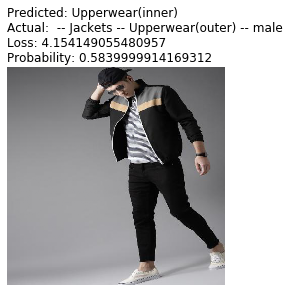

In [16]:
interp.plot_multi_top_losses(samples = 4, figsize=(4,4))

**What's fishy about the above plots:**

1.   It shows highest loss in the validation data is 8.60 which is not true. I'll prove that later in the notebook.
2.   The model has 98.5 % accuracy in the validation set and it can't even differentiate between pants and swimwear!
3.   It does not give the entire prediction of the model, just gives the class that was misclassified.
4.   It says 54 misclassified in 17570 . That means we have an accuracy of 99.69 %. But earlier we saw the accuracy was 98.53 %
5.   Now, look at the probability of each misclassified class. We have a probability of more than 0.99 for the second image. Generally, misclassified classes are predicted with low probability. Either that or the model sucks!

**To know better we have to dig deeper into the fastai source code !!**



**This is plot_multi_top_losses() method in ClassificationInterpretation class. Have a look ** 



```
def _cl_int_plot_multi_top_losses(self, samples:int=3, figsize:Tuple[int,int]=(8,8), save_misclassified:bool=False):
    "Show images in `top_losses` along with their prediction, actual, loss, and probability of predicted class in a multilabeled dataset."
    if samples >20:
        print("Max 20 samples")
        return
    losses, idxs = self.top_losses(self.data.c)
    l_dim = len(losses.size())
    if l_dim == 1: losses, idxs = self.top_losses()
    infolist, ordlosses_idxs, mismatches_idxs, mismatches, losses_mismatches, mismatchescontainer = [],[],[],[],[],[]
    truthlabels = np.asarray(self.y_true, dtype=int)
    classes_ids = [k for k in enumerate(self.data.classes)]
    predclass = np.asarray(self.pred_class)
    for i,pred in enumerate(predclass):
        where_truth = np.nonzero((truthlabels[i]>0))[0]
        mismatch = np.all(pred!=where_truth)
        if mismatch:
            mismatches_idxs.append(i)
            if l_dim > 1 : losses_mismatches.append((losses[i][pred], i))
            else: losses_mismatches.append((losses[i], i))
        if l_dim > 1: infotup = (i, pred, where_truth, losses[i][pred], np.round(self.preds[i], decimals=3)[pred], mismatch)
        else: infotup = (i, pred, where_truth, losses[i], np.round(self.preds[i], decimals=3)[pred], mismatch)
        infolist.append(infotup)
    ds = self.data.dl(self.ds_type).dataset
    mismatches = ds[mismatches_idxs]
    ordlosses = sorted(losses_mismatches, key = lambda x: x[0], reverse=True)
    for w in ordlosses: ordlosses_idxs.append(w[1])
    mismatches_ordered_byloss = ds[ordlosses_idxs]
    print(f'{str(len(mismatches))} misclassified samples over {str(len(self.data.valid_ds))} samples in the validation set.')
    samples = min(samples, len(mismatches))
    for ima in range(len(mismatches_ordered_byloss)):
        mismatchescontainer.append(mismatches_ordered_byloss[ima][0])
    for sampleN in range(samples):
        actualclasses = ''
        for clas in infolist[ordlosses_idxs[sampleN]][2]:
            actualclasses = f'{actualclasses} -- {str(classes_ids[clas][1])}'
        imag = mismatches_ordered_byloss[sampleN][0]
        imag = show_image(imag, figsize=figsize)
        imag.set_title(f"""Predicted: {classes_ids[infolist[ordlosses_idxs[sampleN]][1]][1]} \nActual: {actualclasses}\nLoss: {infolist[ordlosses_idxs[sampleN]][3]}\nProbability: {infolist[ordlosses_idxs[sampleN]][4]}""",
                        loc='left')
        plt.show()
        if save_misclassified: return mismatchescontainer
```



Let's find out what self.top_losses() returns.

In [17]:
losses, idxs = interp.top_losses()
print("Losses: ", losses)
print("indexes: ", idxs)

Losses:  tensor([12.5178, 12.4926, 12.2123,  ...,  0.0000,  0.0000,  0.0000])
indexes:  tensor([ 46149,  46135, 137789,  ..., 312634,  91048,  30387])


Seems like losses contains all the losses sorted in descending order and idxs contains their respective indexes. 

Turns out the **top loss isn't 8.60 after all. It's 12.5178!** 
But what are those loss indexes?

**Index 130253 !!!**

But we only have 17570 validation images.


Lets find out what is the maximum index in the array

In [0]:
# we arrange the idxs in descending order and look at the first element
sorted(idxs, reverse = True )[0]

tensor(421679)

Since the max index is 421679 , total losses losses must be 421680.

What's special about that number! Turns out `24 * 17570 = 421680`.
We have 24 classes in total. That means for each image we will have 24 different losses. Hence we have `24 * 17570` in total.
That solves our first mystery

**Moving on to our next mystery!**


```
self.predclass
```
Let's find out what's inside it.


In [0]:
preds = interp.pred_class
print('predclass:', preds)
print('Shape of predclass:', preds.shape)
print('Length of predclass:', len(preds))

predclass: tensor([22, 23, 22,  ..., 22, 23, 23])
Shape of predclass: torch.Size([17570])
Length of predclass: 17570


It's just a one-dimensional tensor containing 17570 values. Looks like each of the 17570 images are classified into one of the 24 labels. That's disappointing!
This is a multilabel classification problem, so we expect each image to have 1 or more labels. Hence, the need for a multidimensional tensor! 

**Is it true that our model is just predicting only one label for one image?** Let's get down the rabbithole and make some predictions!

True Labels: male Suits Fullbodywear
Predicted Labels: Fullbodywear;Suits;male


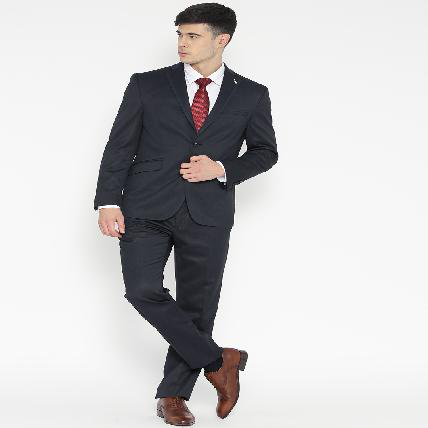

In [0]:
# taking out a random sample from the data
sample = np.random.randint(0,50000)
print("True Labels:",df['LABELS'][sample])
img = open_image(df['PATH'][sample])
a,b,c = learn.predict(img)
print("Predicted Labels:",a)
img

Okay, the model is good. Something is wrong with the predclass.

**Since the code does not use the correct predictions, it can't be relied on any further!**

*It is enough motivaton to write my own code for plotting top losses!*

**Interpretation of Multilabel Classification Problem using factory method was giving bad results, so I wrote my own code for it. I am planning to make a pull request to fastai soon**

Instead of using `interp.pred_class`. I use `interp.preds`. This gives a better representation of predictions made.

In [0]:
probabilities = interp.preds
print('Predictions:', probabilities )
print('Shape of predictons:', probabilities .shape)
print('Length of predictions:', len(probabilities))

Predictions: tensor([[9.5449e-01, 9.5061e-01, 2.8346e-07,  ..., 4.3716e-07, 9.9897e-01,
         9.7381e-04],
        [9.1975e-01, 9.8443e-01, 4.9313e-07,  ..., 1.0569e-05, 2.6189e-05,
         9.9997e-01],
        [2.8169e-03, 1.9609e-04, 3.4131e-06,  ..., 9.9770e-01, 9.9999e-01,
         1.2078e-05],
        ...,
        [4.2803e-05, 1.4096e-06, 1.2051e-05,  ..., 1.1860e-04, 9.9998e-01,
         2.2439e-05],
        [8.3612e-05, 9.9986e-01, 4.2543e-08,  ..., 3.5591e-07, 3.0085e-05,
         9.9997e-01],
        [2.8426e-03, 1.2347e-04, 2.6323e-05,  ..., 5.8376e-06, 1.0060e-04,
         9.9991e-01]])
Shape of predictons: torch.Size([17570, 24])
Length of predictions: 17570


We get the probablities for each of the 24 classes for each of the 17570 images.
With a little more tweaking we can get the predicted classes for all images.


In [20]:
# predictions for first image(image at index 0)
predlabels = np.asarray(interp.preds>0.57, dtype=int)# since our accuracy threshold was 0.57
print("Predicted Labels indices for 0th image:",np.nonzero((predlabels[0]>0))[0] )
classes_ids = [k for k in enumerate(interp.data.classes)]
print("Predicted classes for 0th image:")
for clas in np.nonzero((predlabels[0]>0))[0]:
  print(classes_ids[clas][1])

Predicted Labels indices for 0th image: [ 4 22]
Predicted classes for 0th image:
Ethnicwear
female


Most variables have the same names as the one in `ClassificationInterpretation.plot_multi_top_losses()` method for coherence, in case I make a PR. 
Some new variables are also created.

In [0]:
#manually created function
infolist, ordlosses_idxs, mismatches_idxs,mismatches, losses_mismatches, mismatchescontainer = [],[],[],[],[],[]
truthlabels_flat = np.array(interp.y_true, dtype=int).flatten()
truthlabels = np.asarray(interp.y_true, dtype=int)
predlabels_flat = np.array(interp.preds>0.57, dtype=int).flatten()
predlabels = np.asarray(interp.preds>0.57, dtype=int)
probs =  np.asarray(interp.preds).flatten()
classes_ids = [k for k in enumerate(interp.data.classes)]
for i, (loss, pred, truth) in enumerate(zip(interp.losses, truthlabels_flat, predlabels_flat)):
  if truth != pred:
    mismatches_idxs.append(i)
    losses_mismatches.append((loss, i))
    row = i// 24
    col = i-(row*24)
    where_truth = np.nonzero((truthlabels[row]>0))[0]
    where_pred  = np.nonzero((predlabels[row]>0))[0]
    infolist.append((i, probs[i], loss.item(), where_truth,  where_pred, col))

In [0]:
ordinfolist = []
ordinfolist = sorted(infolist, key = lambda x: x[2], reverse=True)

In [23]:
ds = interp.data.dl(interp.ds_type).dataset
row =np.array(mismatches_idxs)//24
mismatches = ds[row]
ordlosses = sorted(losses_mismatches, key = lambda x: x[0], reverse=True)
ordlosses_idxs= []
for w in ordlosses: ordlosses_idxs.append(w[1])
row = np.array(ordlosses_idxs)//24
mismatches_ordered_byloss = ds[row]
total = len(interp.data.valid_ds) * data.c
print(f'{str(len(mismatches))} misclassified predictions over {str(len(interp.data.valid_ds) * data.c)} predictions in the validation set.')
print("Accuracy:",(total-len(mismatches))/total )

6218 misclassified predictions over 421680 predictions in the validation set.
Accuracy: 0.9852542212103965


**Voila! we landed the same accuracy as the one obtained at the end of training.**

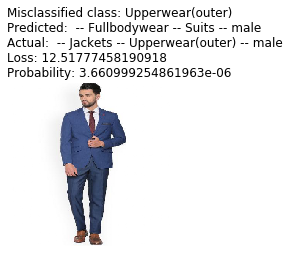

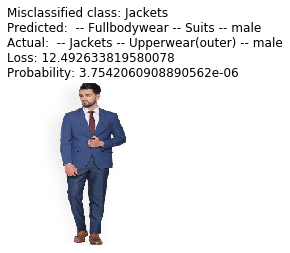

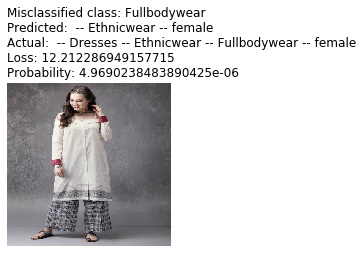

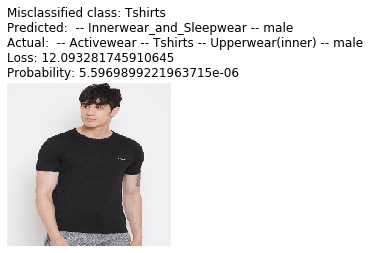

In [82]:
samples = 4
for sampleN in range(samples):
    actualclasses = ''
    for clas in ordinfolist[sampleN][3]:
      actualclasses = f'{actualclasses} -- {str(classes_ids[clas][1])}'# works till here
    predclasses =''
    for clas in ordinfolist[sampleN][4]:
      predclasses = f'{predclasses} -- {str(classes_ids[clas][1])}'# works till here  
      
    imag = mismatches_ordered_byloss[sampleN][0]
    # crosspred,_,_ = learn.predict(imag)
    misclassified_class = classes_ids[ordinfolist[sampleN][5]][1]
    imag = show_image(imag, figsize=(3,3))
    imag.set_title(f"""Misclassified class: {misclassified_class} \nPredicted: {predclasses} \nActual: {actualclasses}\nLoss: {ordinfolist[sampleN][2]}\nProbability: {ordinfolist[sampleN][1]}""",
                    loc='left')
    plt.show()

## **So, let's compare our results with the factorymethod results**

1.   Our top is exactly 12.5178.
2.   Our accuracy matches the model accuracy.
3.   We display the entire prediction besides the misclassified class.
4.   The probabilities of the misclassified classes are very low.



In [0]:
learn.export(path/'export.pkl') # exports the model as a pickle file. You can use it to make your own webapp

True Labels: female Ethnicwear
Predicted Labels: Upperwear(outer);female


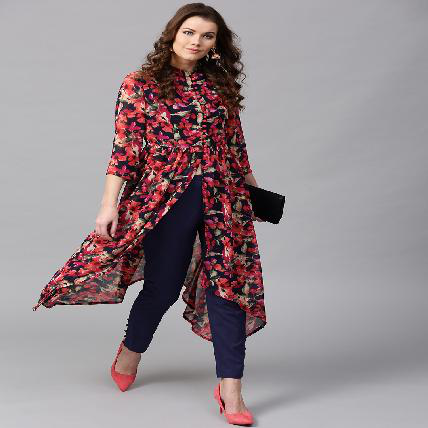

In [25]:
# taking out a random sample from the data
sample =np.random.randint(0,50000)
print("True Labels:",df['LABELS'][sample])
img = open_image(df['PATH'][sample])
a,b,c = learn.predict(img)
print("Predicted Labels:",a)
img